# Introduction
In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video). This will help us extract topics of discussion. We use the embeddings generated in Assignment 4 as input. (This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/') Each of our comments has been assigned a vector that encodes information about its meaning. The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality. We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them. To do this we reduce the dimensionality of the embeddings again to two dimensions. Then we render a scatterplot of our data.
Furthermore we want to analyze and interpret our clusters. To do this, we:

print some statistics about each of the clusters
print cluster's medoid (the central sample)
print the cluster(s) we want to analyze further
Check to see if jupyter lab uses the correct python interpreter with '!which python'. It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac). If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!where python

C:\Users\fluhrer\AppData\Local\Continuum\anaconda3\envs\[seminar]\python.exe


# Install dependencies:

In [7]:
install_packages = True
if install_packages: 
    !conda install tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge tensorflow-hub -y
    !conda install -c akode html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\fluhrer\AppData\Local\Continuum\anaconda3\envs\[seminar]

  added / updated specs:
    - tensorflow=2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.10.14 |                0         159 KB
    openssl-1.1.1h             |       he774522_0         5.8 MB
    yarl-1.6.3                 |   py36h2bbff1b_0         134 KB
    ------------------------------------------------------------
                                           Total:         6.0 MB

The following NEW packages will be INSTALLED:

  _tflow_select      pkgs/main/win-64::_tflow_select-2.2.0-eigen
  absl-py            pkgs/main/win-64::absl-py-0.11.0-py36haa95532_0
  aiohttp            pkgs/main/win-64::aiohttp-3.6.3-py36he774522_0
  astor              pkgs/main/win-64::astor-0.8.1-py36_0
  async-timeout      pkgs

# Imports


In [8]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [9]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')

# Set pandas print options
This will improve readability of printed pandas dataframe.

In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [11]:
os.getcwd()

'C:\\Users\\fluhrer\\Nextcloud\\Sonstiges Lernen\\Critical Social Media Analysis'

In [12]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe. And load the embeddings as a numpy ndarray (a matrix in our case).

In [13]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [14]:
data.head()

,publishedAt,authorName,text,isReply,cleaned,label_manual
0,11/9/2020 13:34,Dietmar Wohlleben,"Naomi Seibt is paid and intensively prepared by Heartland &quot;Institute&quot;, a tobacco &amp; CO2 (coal, gas,petrol industry) lobby group, which she places with severall extreme right-wing and Russian television stations for interviews. See <a href=""https://en.wikipedia.org/wiki/The_Heartland_Institute"">https://en.wikipedia.org/wiki/The_Heartland_Institute</a><br />Seibt is also a member of the right-wing extremist organization &quot;Junge Alternative&quot; , which the German Office for the Protection of the Constitution considers unconstitutional.",0,"Naomi Seibt is paid and intensively prepared by Heartland ""Institute"", a\ntobacco & CO2 (coal, gas,petrol industry) lobby group, which she places with\nseverall extreme right-wing and Russian television stations for interviews.\nSee \nSeibt is also a member of the right-wing extremist organization ""Junge\nAlternative"" , which the German Office for the Protection of the Constitution\nconsiders unconstitutional.\n\n",-1.0
1,11/1/2020 8:03,Rene van Westen,"Both Naomi and Greta are amazing young woman. OK, Greta is more agressive in her speech. At <a href=""https://www.youtube.com/watch?v=9zrHs3dv7LQ&amp;t=3m39s"">3:39</a>, humans have no contribution: Well, not the way most think. But just by being here on this earth with 7.5 bil people, yeah off course we contribute for a part. But as arrogant as we are, we dont want to see that.",0,"Both Naomi and Greta are amazing young woman. OK, Greta is more agressive in\nher speech. At 3:39, humans have no contribution: Well, not the way most\nthink. But just by being here on this earth with 7.5 bil people, yeah off\ncourse we contribute for a part. But as arrogant as we are, we dont want to\nsee that.\n\n",-1.0
2,10/30/2020 19:49,Henni,Wenn du mündliche Prüfung in englisch hast,0,Wenn du mündliche Prüfung in englisch hast\n\n,-1.0
3,10/29/2020 17:18,cameron zero,Wow 2019 so many years of experience and scientific knowledge,0,Wow 2019 so many years of experience and scientific knowledge\n\n,-1.0
4,10/29/2020 9:12,Dave Clarke,"Why so many dislikes? Nothing Naomi said was that offensive to the intellect, surely.",0,"Why so many dislikes? Nothing Naomi said was that offensive to the intellect,\nsurely.\n\n",-1.0


In [15]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP
We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. The number of dimensions (num_dimensions) depends on the number of samples

In [16]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.40307608
n_clusters: 102 silhouette_avg: 0.31515378
n_clusters: 202 silhouette_avg: 0.31238306
n_clusters: 302 silhouette_avg: 0.31096715
n_clusters: 402 silhouette_avg: 0.31048435
n_clusters: 502 silhouette_avg: 0.31273568
n_clusters: 602 silhouette_avg: 0.29777566
n_clusters: 702 silhouette_avg: 0.29200423
n_clusters: 802 silhouette_avg: 0.28143895
n_clusters: 902 silhouette_avg: 0.26089263


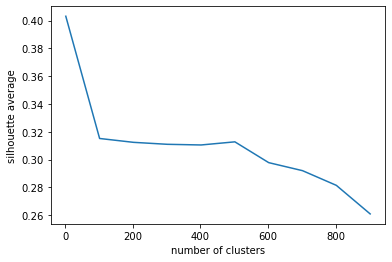

In [17]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=1000 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [18]:
number_of_clusters =  100
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 97     2
89     2
55     2
70     3
65     3
57     3
77     4
80     4
42     4
88     5
56     5
83     5
95     5
27     6
61     6
63     6
54     6
24     7
41     7
75     7
58     7
5      8
8      8
84     8
85     8
73     8
39     9
87     9
53     9
99     9
43     9
40     9
16    10
78    10
82    10
90    10
36    10
29    11
25    11
66    11
49    11
68    11
96    12
30    12
51    12
48    13
59    13
81    13
45    13
32    13
50    14
67    14
21    14
6     15
69    15
31    15
52    16
47    16
44    16
76    16
15    16
71    16
74    17
92    17
93    17
26    18
94    18
12    19
22    19
98    19
1     19
86    19
13    20
79    20
72    20
28    21
0     21
14    22
2     22
10    22
17    23
62    24
35    26
91    26
64    27
23    27
9     27
33    29
37    31
60    32
19    32
18    33
20    33
38    35
7     36
4     38
46    38
11    42
3     50
34    51
Name: label_kmedoids, dtype: int64


In [19]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [20]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

C:\Users\fluhrer\AppData\Local\Continuum\anaconda3\envs\[seminar]\lib\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

In [21]:
len(embeddings_umap_2d)

1592

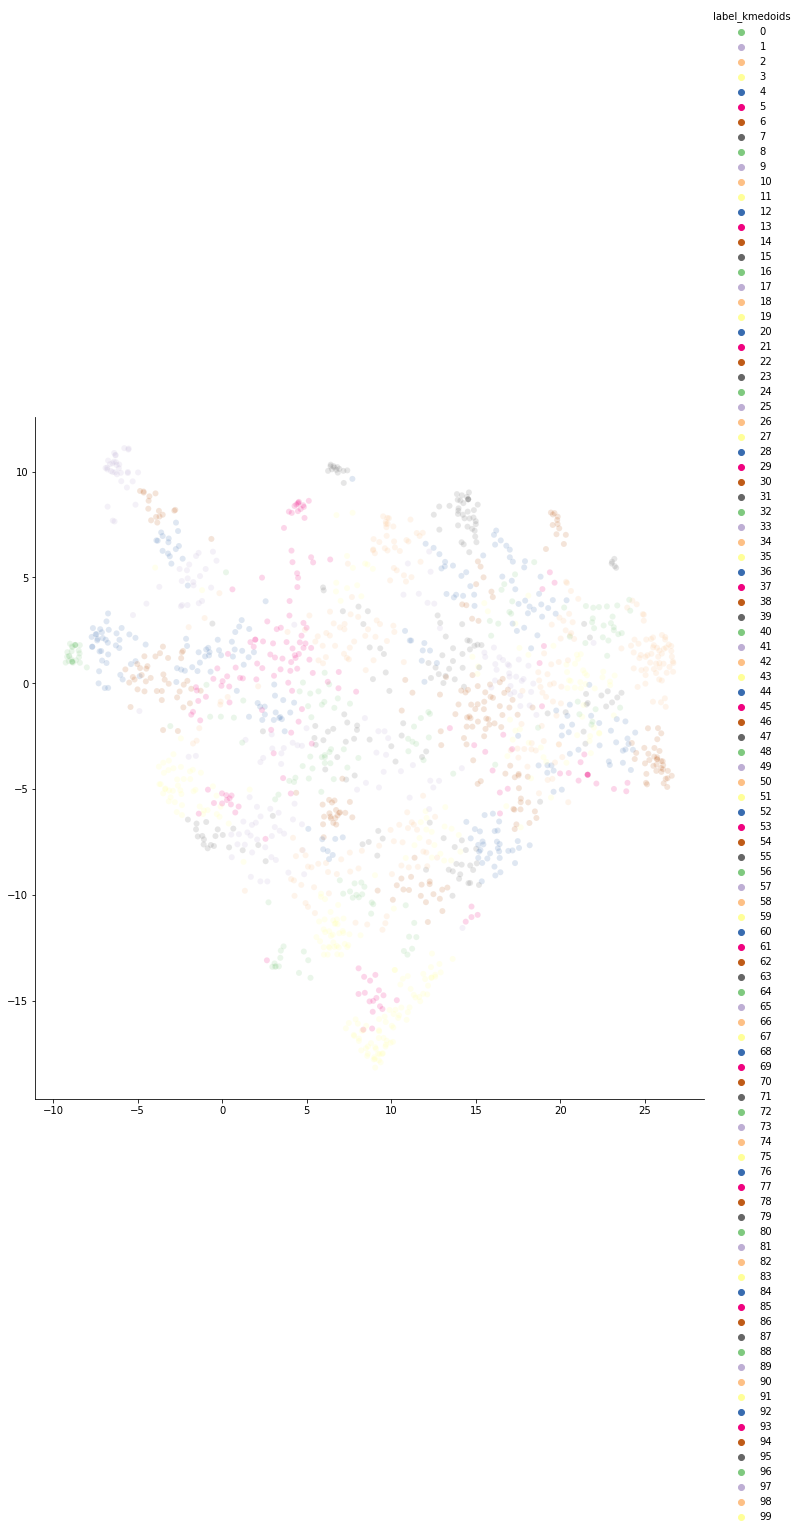

In [22]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)

# Highlight one cluster

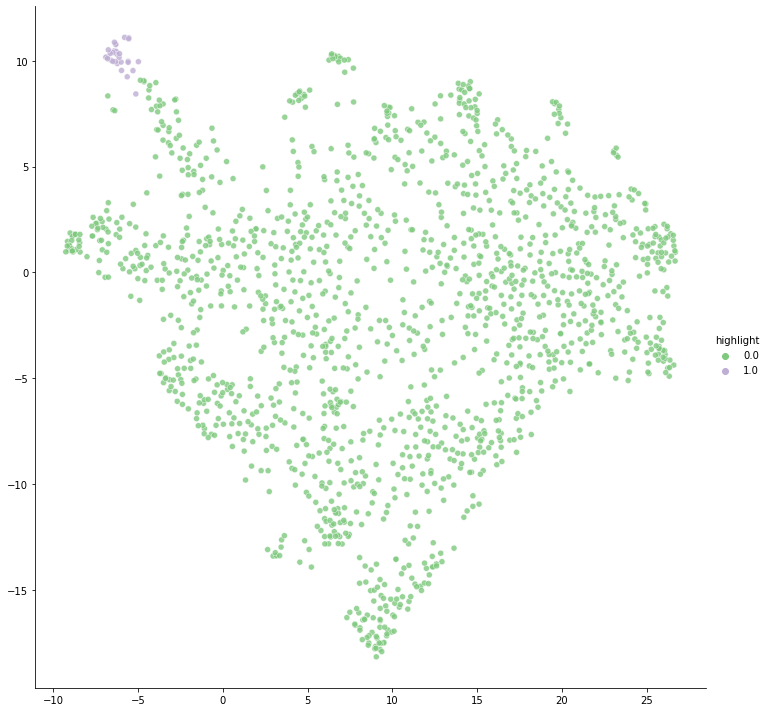

In [45]:
## Choose a cluster to higlight:
cluster_num = 33
data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)

# Print Medoids and cluster statistics

In [38]:
# print the medoids 
data.iloc[medoids_indices]

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
92,7/3/2020 0:27,Joshua Fischer,"We had a very brave weatherman in Germany, he took some minutes of the news to explain that scientist found out, before billions of years was the CO2 emmission very very stronger than nowadays. The important thing is, it happenend meanwhile an ice age. How is that possible, before billions of years more CO2 and an ice age, and now less CO2 and no ice age?",0,"We had a very brave weatherman in Germany, he took some minutes of the news to\nexplain that scientist found out, before billions of years was the CO2\nemmission very very stronger than nowadays. The important thing is, it\nhappenend meanwhile an ice age. How is that possible, before billions of years\nmore CO2 and an ice age, and now less CO2 and no ice age?\n\n",-1.0,0,0.000000e+00,0.0
247,3/7/2020 17:43,Waya Hedia,AOC needs to subscribe to her channel and LEARN SOMETHING.,0,AOC needs to subscribe to her channel and LEARN SOMETHING.\n\n,-1.0,1,1.192093e-07,0.0
1419,2/28/2020 21:49,Stanley Goddard,"@Velvett Blue Are you daft? You just made things up, pretended to be superior, then wimped out of answering any of your ""I have these gut feelings"" comments.",1,"@Velvett Blue Are you daft? You just made things up, pretended to be superior,\nthen wimped out of answering any of your ""I have these gut feelings"" comments.\n\n",-1.0,2,0.000000e+00,0.0
264,3/9/2020 6:56,AOC and NINA 2024 Bye fascism,What stuff does naomi seibt know?? Please share her wisdom.,1,What stuff does naomi seibt know?? Please share her wisdom.\n\n,-1.0,3,4.768372e-07,0.0
601,5/29/2020 12:12,Marcel Bork,@Tee No.,1,@Tee No.\n\n,-1.0,4,0.000000e+00,0.0
16,10/22/2020 4:31,Robb Moody,Smart young lady. The rest of you alarmists should get educated before you open your mouths.,0,Smart young lady. The rest of you alarmists should get educated before you\nopen your mouths.\n\n,-1.0,5,0.000000e+00,0.0
589,10/19/2020 5:42,Sebastian R,"@Tony Maccaroni My parents are fluent in three languages, but don’t understand a word in Englisch. But I don’t know many Europeans not speaking at least one foreign language.",1,"@Tony Maccaroni My parents are fluent in three languages, but don’t understand\na word in Englisch. But I don’t know many Europeans not speaking at least one\nforeign language.\n\n",-1.0,6,0.000000e+00,0.0
1461,2/29/2020 4:11,Doodle Bob,@Stanley Goddard Hi Greta you still pushing your agenda while skipping school flying in planes and riding yachts that cause pollution?,1,@Stanley Goddard Hi Greta you still pushing your agenda while skipping school\nflying in planes and riding yachts that cause pollution?\n\n,-1.0,7,0.000000e+00,0.0
667,3/3/2020 20:40,Al woo,@Rachel Henry thats a no then?,1,@Rachel Henry thats a no then?\n\n,-1.0,8,0.000000e+00,0.0
1508,2/28/2020 20:12,Thomas Ullmann,@Sovereign Rex The sole arbitrators of what is true is evidence combined with with an argument that is both sound and valid. My area of research has been non-equilibrium processes and more broadly stochastic processes. Various climate models can be descri,1,@Sovereign Rex The sole arbitrators of what is true is evidence combined with\nwith an argument that is both sound and valid. My area of research has been\nnon-equilibrium processes and more broadly stochastic processes. Various\nclimate models can be descri\n\n,-1.0,9,0.000000e+00,0.0


In [39]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  21 mean distance from center:  0.0012621992937056348 Proportion of replies: 95.23809523809524
1 number of samples:  19 mean distance from center:  0.0012027589946228545 Proportion of replies: 15.789473684210526
2 number of samples:  22 mean distance from center:  0.0016163696272997186 Proportion of replies: 100.0
3 number of samples:  50 mean distance from center:  0.000713825238563004 Proportion of replies: 16.0
4 number of samples:  38 mean distance from center:  0.0009152449820248876 Proportion of replies: 63.1578947368421
5 number of samples:  8 mean distance from center:  0.002224743366241455 Proportion of replies: 50.0
6 number of samples:  15 mean distance from center:  0.0005269050689094001 Proportion of replies: 66.66666666666667
7 number of samples:  36 mean distance from center:  0.0005587935447692871 Proportion of replies: 100.0
8 number of samples:  8 mean distance from center:  0.00028759241104125977 Proportion of replies: 100.0
9 number of samples: 

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [ ]:
# Choose a cluster to print
cluster_number =   60
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
    number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to? min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label label_manual: your label

In [46]:
#which cluster would you like to assign labels to?
cluster_number = 33
#your label
label_manual = 'language'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [41]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
446,3/3/2020 18:43,rayossmioss Boss,Auch wenn ich nichts verstehe,0,Auch wenn ich nichts verstehe\n\n,climate_change_prevention,33,1.788139e-07,1.0
74,8/20/2020 17:37,Jamie Windle language learning,Fresse bitte 😳,0,Fresse bitte 😳\n\n,climate_change_prevention,33,5.364418e-07,1.0
724,3/1/2020 16:25,another ONE,Interviewt doch gleich den Faschisten Bernd Höcke<br />Ist genauso scheiße,0,Interviewt doch gleich den Faschisten Bernd Höcke \nIst genauso scheiße\n\n,climate_change_prevention,33,5.960464e-07,1.0
289,3/6/2020 0:18,KG,"Obwohl ich nicht alles verstanden habe..sorry, bin ich sicher du wirst eine Menge Menschen erreichen. Ich kenne deine deutschen Videos..Danke für deine Arbeit.",0,"Obwohl ich nicht alles verstanden habe..sorry, bin ich sicher du wirst eine\nMenge Menschen erreichen. Ich kenne deine deutschen Videos..Danke für deine\nArbeit.\n\n",climate_change_prevention,33,5.960464e-07,1.0
586,11/3/2020 11:45,Peter Hallenbach,"@Jaakti, sie ist definitiv besser als Greta.",1,"@Jaakti, sie ist definitiv besser als Greta.\n\n",climate_change_prevention,33,6.556511e-07,1.0
302,3/8/2020 18:43,Enrico Cavallo,"Deutschland GmbH, oder was? Au weia. Allein dass du so einen Quatsch schreiben kannst, zeigt doch, dass du jede Menge Freiheit genießt. Du hast keine Ahnung, was es wirklich bedeutet, nicht frei zu sein.",1,"Deutschland GmbH, oder was? Au weia. Allein dass du so einen Quatsch schreiben\nkannst, zeigt doch, dass du jede Menge Freiheit genießt. Du hast keine Ahnung,\nwas es wirklich bedeutet, nicht frei zu sein.\n\n",climate_change_prevention,33,6.556511e-07,1.0
834,3/1/2020 14:39,Die Affenheit,Jetzt sind auch klimakritiker nazis,1,Jetzt sind auch klimakritiker nazis\n\n,climate_change_prevention,33,6.556511e-07,1.0
2,10/30/2020 19:49,Henni,Wenn du mündliche Prüfung in englisch hast,0,Wenn du mündliche Prüfung in englisch hast\n\n,climate_change_prevention,33,8.344650e-07,1.0
590,9/23/2020 23:15,Dumm Kopf,"@Jaakti Sie wissen schon, dass der Nationalsozialismus ursprünglich von Italien kommt oder?",1,"@Jaakti Sie wissen schon, dass der Nationalsozialismus ursprünglich von\nItalien kommt oder?\n\n",climate_change_prevention,33,8.344650e-07,1.0
274,3/6/2020 13:20,EstrellaPolux,wieso kann die so gut Englisch ?,0,wieso kann die so gut Englisch ?\n\n,climate_change_prevention,33,8.940697e-07,1.0


# Print Cluster 2

In [43]:
# Choose a cluster to print
cluster_number =  32
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
    number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

Number of samples in the cluster: 13
Average Distance from cluster center: 1.4438079e-05


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
44,9/24/2020 13:09,Hamada El,No we are not. This is bullshit. And you Reichsbürger are running the country into hell.,1,No we are not. This is bullshit. And you Reichsbürger are running the country\ninto hell.\n\n,-1,32,0.000000,0.0
1090,2/29/2020 12:50,gavin murray,"Hey this is what I think— every far leftist reply ""No! You're racist!""",1,"Hey this is what I think— every far leftist reply ""No! You're racist!""\n\n",-1,32,0.000004,0.0
183,3/10/2020 20:19,Daryl Williams,"This place is like a gathering of fringe cultists. Actually, not so much &#39;like&#39; as just &#39;is&#39;.",0,"This place is like a gathering of fringe cultists. Actually, not so much\n'like' as just 'is'.\n\n",-1,32,0.000008,0.0
917,2/29/2020 19:54,gary richardson,"The only one dishing out propaganda is YOU, princess.",0,"The only one dishing out propaganda is YOU, princess.\n\n",-1,32,0.000008,0.0
1367,2/28/2020 20:47,Andrew Davies,An obvious puppet of the alt right-or...say it as it is- EFFING Fascist scumbag thickos.,0,An obvious puppet of the alt right-or...say it as it is- EFFING Fascist\nscumbag thickos.\n\n,-1,32,0.000010,0.0
896,2/29/2020 23:14,Pat Keane,Facts apparently mean nothing to her.,0,Facts apparently mean nothing to her.\n\n,-1,32,0.000015,0.0
1362,2/29/2020 4:07,Doodle Bob,How do I report people for spreading misinformation?,1,How do I report people for spreading misinformation?\n\n,-1,32,0.000016,0.0
1488,2/29/2020 17:44,Danny Green,"@John Blaid Well said, but then again you're talking to the indoctrinated. They're the ones yelling the loudest right now. It's time for the grown ups to start speaking the truth. Keep up the good fight.",1,"@John Blaid Well said, but then again you're talking to the indoctrinated.\nThey're the ones yelling the loudest right now. It's time for the grown ups to\nstart speaking the truth. Keep up the good fight.\n\n",-1,32,0.000017,0.0
1059,2/29/2020 13:14,FranzKafkaRockOpera,"You are the world's biggest sucker if you think this explicit puppet of far-right parties is in any meaningful sense more trustworthy than the ""mainstream"", whatever than means.",1,"You are the world's biggest sucker if you think this explicit puppet of far-\nright parties is in any meaningful sense more trustworthy than the\n""mainstream"", whatever than means.\n\n",-1,32,0.000020,0.0
1361,2/29/2020 5:33,John Goodson,Seriously keep it up bro. The world needs more people like you. I doubt the magic sky god will save us from these idiot morons that seem to be everywhere these days. Where do they even come from? I think their mothers must have been drinking too much during pregnancy.,1,Seriously keep it up bro. The world needs more people like you. I doubt the\nmagic sky god will save us from these idiot morons that seem to be everywhere\nthese days. Where do they even come from? I think their mothers must have been\ndrinking too much during pregnancy.\n\n,-1,32,0.000020,0.0


In [47]:
#which cluster would you like to assign labels to?
cluster_number = 64
#your label
label_manual = 'misinformation'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [48]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
346,3/4/2020 20:30,shane Baxter!,Lol,0,Lol\n\n,misinformation,64,0.000000e+00,0.0
288,3/6/2020 5:25,Bumptytime Two,"<a href=""http://www.wrongkindofgreen.org/2019/01/17/the-manufacturing-of-greta-thunberg-for-consent-the-political-economy-of-the-non-profit-industrial-complex/"">http://www.wrongkindofgreen.org/2019/01/17/the-manufacturing-of-greta-thunberg-for-consent-the-political-economy-of-the-non-profit-industrial-complex/</a>",0,\nthunberg-for-consent-the-political-economy-of-the-non-profit-industrial-\ncomplex/\n\n,misinformation,64,1.192093e-07,0.0
405,3/4/2020 13:07,Olive LG,"<a href=""http://www.youtube.com/results?search_query=%23climaterealist"">#climaterealist</a>",0,#climaterealist\n\n,misinformation,64,2.384186e-07,0.0
335,3/4/2020 22:21,Gilles Roger,❤️🏆🛡️,0,❤️🏆🛡️\n\n,misinformation,64,4.768372e-07,0.0
54,9/13/2020 11:28,Kevin Shawn Trölitzsch,Naomi👍😊👌,0,Naomi👍😊👌\n\n,misinformation,64,5.364418e-07,0.0
1155,2/29/2020 17:08,JBW,CATFIGHT!,1,CATFIGHT!\n\n,misinformation,64,5.960464e-07,0.0
19,10/19/2020 14:04,Kellners Hodenzwicker,"<a href=""https://www.volksverpetzer.de/corona-faktencheck/pcr-test-naomi-seibt/?fbclid=IwAR14oxnSakPKkzvPJNCoHI2f9_FBW7Lf1UytkP1opvc1IeZqiNlfgzST2ms"">https://www.volksverpetzer.de/corona-faktencheck/pcr-test-naomi-seibt/?fbclid=IwAR14oxnSakPKkzvPJNCoHI2f9_FBW7Lf1UytkP1opvc1IeZqiNlfgzST2ms</a>",0,\nseibt/?fbclid=IwAR14oxnSakPKkzvPJNCoHI2f9_FBW7Lf1UytkP1opvc1IeZqiNlfgzST2ms\n\n,misinformation,64,6.556511e-07,0.0
1024,2/29/2020 10:32,Petra,Nein,1,Nein\n\n,misinformation,64,6.556511e-07,0.0
630,3/3/2020 13:43,Anton Szandor,Herman?,1,Herman?\n\n,misinformation,64,8.344650e-07,0.0
72,8/25/2020 12:07,Geovanny Mora,"<a href=""https://www.youtube.com/watch?v=9zrHs3dv7LQ&amp;t=2m05s"">2:05</a>",0,2:05\n\n,misinformation,64,9.536743e-07,0.0
